In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sweetviz as sv
from rdkit.Chem import rdChemReactions
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem

In [2]:
from IPython.display import display
from PIL import Image
import io

In [3]:
def count_num_reaction(data):
    '''Count how many reactions there are'''
    rxnCount_data = data['Reaction ID'].nunique()
    print('Number of Reactions:', rxnCount_data)
    print('Number of Rows:', data.shape[0])

def view_reactionScheme(data, NumReaction_to_view, duplicate):
    '''pick and show reaction scheme '''

    if duplicate == 'drop duplicate':
        Reaction_data = data.drop_duplicates(subset=['Reaction ID'], keep='first')
        Reaction_data = Reaction_data.reset_index(drop=True)
    elif duplicate == 'keep duplicate': 
        Reaction_data = data.reset_index(drop=True)
    else:
        raise ValueError('Invalid input')
        
    if NumReaction_to_view > Reaction_data.shape[0]:
        raise ValueError('Number of reactions to view is more than the total number of reactions in the dataset')
    else:
        # Draw
        random_start = np.random.randint(0, (Reaction_data.shape[0] - NumReaction_to_view + 1) , size=1)[0]
        for idx, row in Reaction_data[random_start: random_start + NumReaction_to_view].iterrows():
            reaction_smarts = row['Reaction']
            rxn = rdChemReactions.ReactionFromSmarts(reaction_smarts, useSmiles=True)
            if rxn:
                print('Reaction ID:', Reaction_data.iloc[idx]['Reaction ID'])
                img = Draw.ReactionToImage(rxn)
                
                # display image in notebook
                with io.BytesIO() as output:
                    img.save(output, format="PNG")
                    display(Image.open(output))
                # Return conditions
                print(row[['Largest Reactant MW', 'Reagent', 'Solvent (Reaction Details)', 'Time (Reaction Details) [h]', 'Temperature (Reaction Details) [C]', 'Yield']])
                print(f'Link: {row["Links to Reaxys"]}\n')




In [4]:
# Change working directory
os.chdir('/Users/suongsuong/Documents/GitHub/Reactivity-based-metric-of-complexity/Reduction of ketone/Notebook/')

## <span style="color:blue">  Import data after checking by change in C-O bonds </span>

In [5]:
SingleReduc_byCObond = pd.read_excel('SingleReduc_byCObond.xlsx')
count_num_reaction(SingleReduc_byCObond)

Number of Reactions: 2210
Number of Rows: 3000


---

## <span style="color:blue"> Select sodium tetrahydroborate as Reagent </span>
#### Starting with reagent because, from EDA of the data after filtering by CO bond, it's the one leaving the most data if filtering

In [6]:

SingleReduc_byCObond['Reagent'] = SingleReduc_byCObond['Reagent'].astype(str)

SingleReduc_NaBH4 = SingleReduc_byCObond[SingleReduc_byCObond['Reagent'].isin({'sodium tetrahydroborate'})]

count_num_reaction(SingleReduc_NaBH4)

Number of Reactions: 1819
Number of Rows: 2030


In [7]:
columns_with_lists = [col for col in SingleReduc_NaBH4.columns if SingleReduc_NaBH4[col].apply(lambda x: isinstance(x, list)).any()]
df = SingleReduc_NaBH4.drop(columns=columns_with_lists)
eda = sv.analyze(df)
eda.show_html(filepath='EDA_NaBH4.html')

                                             |          | [  0%]   00:00 -> (? left)

/Users/suongsuong/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts_without_nan = pd.Series()


Report Notebook/EDA_NaBH4.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## <span style="color:blue"> Select methanol as solvent </span>
#### Continue with Solvent because for the same reason as for Reagent
#### Pick methanol as it has most data

In [8]:
SingleReduc_methanol= SingleReduc_NaBH4[SingleReduc_NaBH4['Solvent (Reaction Details)'] == 'methanol']

count_num_reaction(SingleReduc_methanol)

Number of Reactions: 1043
Number of Rows: 1133


In [9]:
columns_with_lists = [col for col in SingleReduc_methanol.columns if SingleReduc_methanol[col].apply(lambda x: isinstance(x, list)).any()]
df = SingleReduc_methanol.drop(columns=columns_with_lists)
eda = sv.analyze(df)
eda.show_html(filepath='EDA_methanol.html')

                                             |          | [  0%]   00:00 -> (? left)

/Users/suongsuong/opt/anaconda3/lib/python3.9/site-packages/sweetviz/series_analyzer.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  value_counts_without_nan = pd.Series()


Report Notebook/EDA_methanol.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## <span style="color:blue"> Select 0 degC for Temperature </span>
## <span style="color:blue"> Select Time of reaction less than 24h </span>

In [10]:
# Temp
SingleReduc_temp = SingleReduc_methanol[SingleReduc_methanol['Temperature (Reaction Details) [C]'] == '0' ] 
print('Temp.:')
print(count_num_reaction(SingleReduc_temp))

# Time
SingleReduc_time = SingleReduc_temp
SingleReduc_time = SingleReduc_temp[SingleReduc_temp['Time (Reaction Details) [h]'] < 24 ] 
print('Time:')
print(count_num_reaction(SingleReduc_time))



Temp.:
Number of Reactions: 492
Number of Rows: 534
None
Time:
Number of Reactions: 491
Number of Rows: 533
None


#### Note that after these filteration. There's no column left with Reagent = 'methanol; sodium tetrahydroborate'

## <span style="color:blue"> Inspect duplicated reactions </span>

In [11]:
# Drop duplicated rows
SingleReduc_duplicate = SingleReduc_time.drop_duplicates()

print(count_num_reaction(SingleReduc_duplicate))

SingleReduc_duplicate['Reaction ID'].value_counts().head(10)

Number of Reactions: 491
Number of Rows: 500
None


5125708     2
10088666    2
2839467     2
50834932    2
4899473     2
40358815    2
5103599     2
1159290     2
32575260    2
2505975     1
Name: Reaction ID, dtype: int64

Reaction ID: 32575260


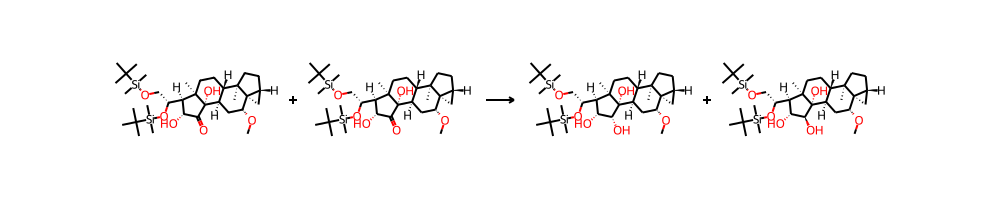

Largest Reactant MW                                   623.036
Reagent                               sodium tetrahydroborate
Solvent (Reaction Details)                           methanol
Time (Reaction Details) [h]                          0.166667
Temperature (Reaction Details) [C]                          0
Yield                                  73 percent; 24 percent
Name: 0, dtype: object
Link: https://www.reaxys.com/reaxys/secured/hopinto.do?context=C&query=CNR.CNR%3D20087673&database=RX&origin=ReaxysOutput&ln=

Reaction ID: 32575260


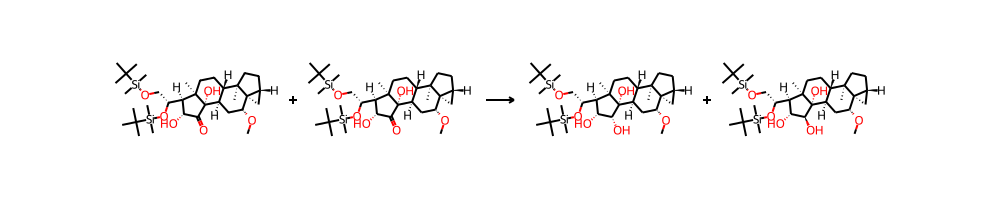

Largest Reactant MW                                   623.036
Reagent                               sodium tetrahydroborate
Solvent (Reaction Details)                           methanol
Time (Reaction Details) [h]                          0.166667
Temperature (Reaction Details) [C]                          0
Yield                                  73 percent; 24 percent
Name: 1, dtype: object
Link: https://www.reaxys.com/reaxys/secured/hopinto.do?context=C&query=CNR.CNR%3D77773165&database=RX&origin=ReaxysOutput&ln=



,Reaction,Reactant,Product,Reagent,Catalyst,Solvent (Reaction Details),Time (Reaction Details) [h],Temperature (Reaction Details) [C],Yield,Reaction ID,Links to Reaxys,Reaction: Links to Reaxys,References,Reactant SMILES,Product SMILES,Change_MW,Largest Reactant MW,Yield (number),change in C-O single bond,change in C=O double bond
2719,[H][C@@]12C[C@@]11[C@@H](C[C@]3([H])[C@]([H])(...,C34H62O6Si2,C34H64O6Si2; C34H64O6Si2,sodium tetrahydroborate,NaN,methanol,0.166667,0,73 percent; 24 percent,32575260,https://www.reaxys.com/reaxys/secured/hopinto....,https://www.reaxys.com/reaxys/secured/hopinto....,"Article; Isaka, Nobuhisa; Tamiya, Minoru; Hase...",['[H][C@@]12C[C@@]11[C@@H](C[C@]3([H])[C@]([H]...,['[H][C@@]12C[C@@]11[C@@H](C[C@]3([H])[C@]([H]...,4.032,623.036,97.0,1,-1
2720,[H][C@@]12C[C@@]11[C@@H](C[C@]3([H])[C@]([H])(...,C34H62O6Si2,C34H64O6Si2; C34H64O6Si2,sodium tetrahydroborate,NaN,methanol,0.166667,0,73 percent; 24 percent,32575260,https://www.reaxys.com/reaxys/secured/hopinto....,https://www.reaxys.com/reaxys/secured/hopinto....,"Article; Tamiya, Minoru; Isaka, Nobuhisa; Kita...",['[H][C@@]12C[C@@]11[C@@H](C[C@]3([H])[C@]([H]...,['[H][C@@]12C[C@@]11[C@@H](C[C@]3([H])[C@]([H]...,4.032,623.036,97.0,1,-1


In [12]:
#### USE THIS CODE TO EXAMINE THE REACTION

Reaction_ID = 32575260
view_reactionScheme(SingleReduc_duplicate[SingleReduc_duplicate['Reaction ID'] == Reaction_ID], 2, 'keep duplicate')
SingleReduc_duplicate[SingleReduc_duplicate['Reaction ID'] == Reaction_ID]

#### <span style="color:salmon"> Reaction ID = 5125708 </span>
Same reaction, conditions, 2 reported yields (96% vs 96.3%) from 2 references with same title, same authors but published in 2 different years in 2 different journals. 

=> Both were actually 96%. Keep the one having 96% yield

#### <span style="color:salmon"> Reaction ID = 10088666 </span> 
Same reaction, conditions, yield, but different references  

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 2839467 </span> 
Same reaction, conditions, references, yield reported as '29.3 percent; 9 percent' and '29.3 percent; 9.0 percent' 

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 50834932 </span> 
Same reaction, different reacting time with 2 different yields 

1h reaction ~ 94% 

0.5h reaction ~ 96% 

=> take average of the yields

#### <span style="color:salmon"> Reaction ID = 4899473 </span> 
Same reaction, conditions, yield, but 2 references 

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 40358815 </span> 
Same reaction, conditions, yield, but 2 references 

=> keep 1, no matter which

#### <span style="color:salmon"> Reaction ID = 5103599 </span> 
Same reaction, different reacting time with 2 different yields 

12h reaction ~ 83% 

0.5h reaction ~ 96.7% 

=> Take average

#### <span style="color:salmon"> Reaction ID = 1159290 </span> 
Same reaction, conditions, 2 references reported 2 different yields

=> Too different. Remove both

#### <span style="color:salmon"> Reaction ID = 32575260 </span> 

Same yield reported (2 references) for same reaction of same reaction conditions.

Check the literatures: the yields are actually 74% and 23% (not 73 and 24) for both. 
Note for later if needed because this difference does not affect the sum for now

=> keep 1, no matter which

#### Based on comments above, handle duplicated rows and update yields. Note for later when verifying reactions with literatures.

In [13]:
id_toremove = [1159290]
id_tokeep1 =[5125708,10088666, 2839467, 50834932, 4899473, 40358815,5103599, 32575260] 

duplicate_rows = SingleReduc_duplicate[SingleReduc_duplicate['Reaction ID'].isin(id_tokeep1)]
duplicate_rows = duplicate_rows.drop_duplicates(subset=['Reaction ID'])

not_duplicate = SingleReduc_duplicate[~SingleReduc_duplicate['Reaction ID'].isin(id_tokeep1)]

SingleReduc_final = pd.concat([duplicate_rows,not_duplicate])

# Update the 'Yield' column for 'Reaction ID' 5125708, 50834932 and 5103599
SingleReduc_final.loc[SingleReduc_final['Reaction ID'] == 50834932, 'Yield (number)'] = 96
SingleReduc_final.loc[SingleReduc_final['Reaction ID'] == 50834932, 'Yield (number)'] = np.average([94,96])
SingleReduc_final.loc[SingleReduc_final['Reaction ID'] == 5103599, 'Yield (number)'] = np.average([83,96.7])

# Remove rows with 'Reaction ID' in id_toremove
SingleReduc_final = SingleReduc_final[~SingleReduc_final['Reaction ID'].isin(id_toremove)]

count_num_reaction(SingleReduc_final)

Number of Reactions: 490
Number of Rows: 490


#### <span style="color:salmon"> Verify duplicated rows by reaction SMILES </span> 

There are 2 reaction are the same but were assigned to different ID: 48228963 and 48228690
Everything else are the same -> keep 1

In [14]:
SingleReduc_final['Reaction'].value_counts().head(3)

[H][C@]12CC[C@]3([H])[C@](CC1=C)(C2=O)C(=O)O[C@@]1([H])C[C@@]2([H])O[C@@]4([H])OC[C@@]31[C@@]4([H])C2(C)C>>[H][C@]12OC[C@]34[C@@]1([H])C(C)(C)[C@@]([H])(C[C@]3([H])OC(=O)[C@]13CC(=C)[C@]([H])(CC[C@@]41[H])[C@H]3O)O2    2
COC(=O)[C@]1(O)CC2=CC(Cl)=CC=C2C1=O>>COC(=O)[C@]1(O)CC2=C(C=CC(Cl)=C2)[C@@H]1O                                                                                                                                             1
O=C1CCC[C@@]2(CCCCC2=O)N1>>O[C@H]1CCCC[C@@]11CCCC(=O)N1                                                                                                                                                                    1
Name: Reaction, dtype: int64

In [15]:
SingleReduc_final = SingleReduc_final.drop_duplicates( subset = 'Reaction')
count_num_reaction(SingleReduc_final)

Number of Reactions: 489
Number of Rows: 489


-----

#### Save data

In [16]:
# Save data
SingleReduc_final.to_excel('SingleReduc_final(no human verified).xlsx', index=False)